##### Step 1. Import necessary tools and libraries

In [153]:
#import necessary packages
import pandas as pd
import numpy as np
import nltk
import re
import contractions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [154]:
#export requirements
#!pip freeze > requirements.txt
#conda env export > environment.yml

##### Step 2. Load dataset for supervised learning

In [155]:
# load train dataset
df = pd.read_csv('train_hurricane_with_name.csv')
df = df.drop_duplicates(subset=['text', 'class_label'], keep=False)  # drop duplicates in dataset
df['date'] =  pd.to_datetime(df['created_at'])

df.head(3)

,Unnamed: 0,tweet_id,text,class_label,hurricane,fatalities,damage(billion USD),author_id,created_at,conversation_id,...,in_reply_to_user_id,attachments,lang,possibly_sensitive,public_metrics,referenced_tweets,reply_settings,source,date,norm_date
0,0,783409770493571076,Horrifying. My heart breaks for Haiti. Thinkin...,sympathy_and_support,matthew,603,16.47,3.031696e+07,2016-10-04 20:53:38+00:00,7.834098e+17,...,no value,no value,en,no value,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[<ReferencedTweet id=783408890222444548 type=q...,everyone,TweetDeck,2016-10-04 20:53:38+00:00,2.052895
1,1,784696725285908481,#BreakingNews Hurricane Matthew kills over 800...,injured_or_dead_people,matthew,603,16.47,2.182497e+09,2016-10-08 10:07:32+00:00,7.846967e+17,...,no value,no value,en,no value,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",no value,everyone,dlvr.it,2016-10-08 10:07:32+00:00,99.741796
2,2,783549594416377856,Southern Haiti effectively cut off after the b...,other_relevant_information,matthew,603,16.47,9.788374e+07,2016-10-05 06:09:15+00:00,7.835496e+17,...,no value,no value,en,no value,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",[<ReferencedTweet id=783548240650244097 type=q...,everyone,Twitter for Windows Phone,2016-10-05 06:09:15+00:00,12.666631


##### Step 3. Basic EDA of train dataset

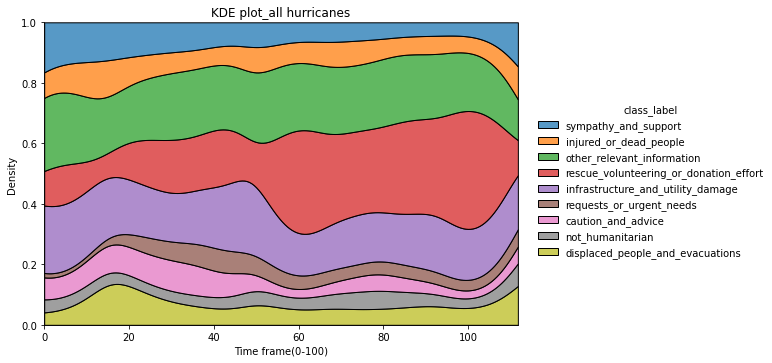

In [119]:
# kernel density estimate plot - all hurricanes
ax_kde = sns.displot(
    data=df,
    x="norm_date", hue="class_label",
    kind="kde", height=5, aspect=1.5,
    multiple="fill", clip=(0, None)
).set(title='KDE plot_all hurricanes', xlabel='Time frame(0-100)', ylabel='Density')

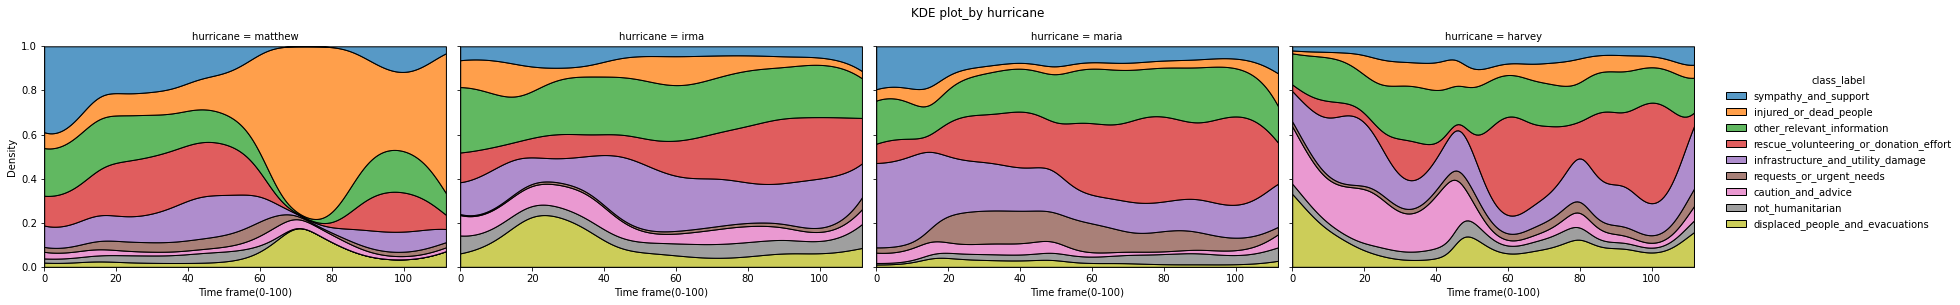

In [120]:
# kernel density estimate plot - by hurricane
ax_kde_by_hurricanes = sns.displot(
    data=df,
    x="norm_date", col='hurricane', hue="class_label",
    kind="kde", height=4, aspect=1.5,
    multiple="fill", clip=(0, None), col_wrap=4
).set(xlabel='Time frame(0-100)', ylabel='Density').fig.suptitle('KDE plot_by hurricane', y=1.05)

Text(0.5, 1.05, 'Histogram_by hurricane')

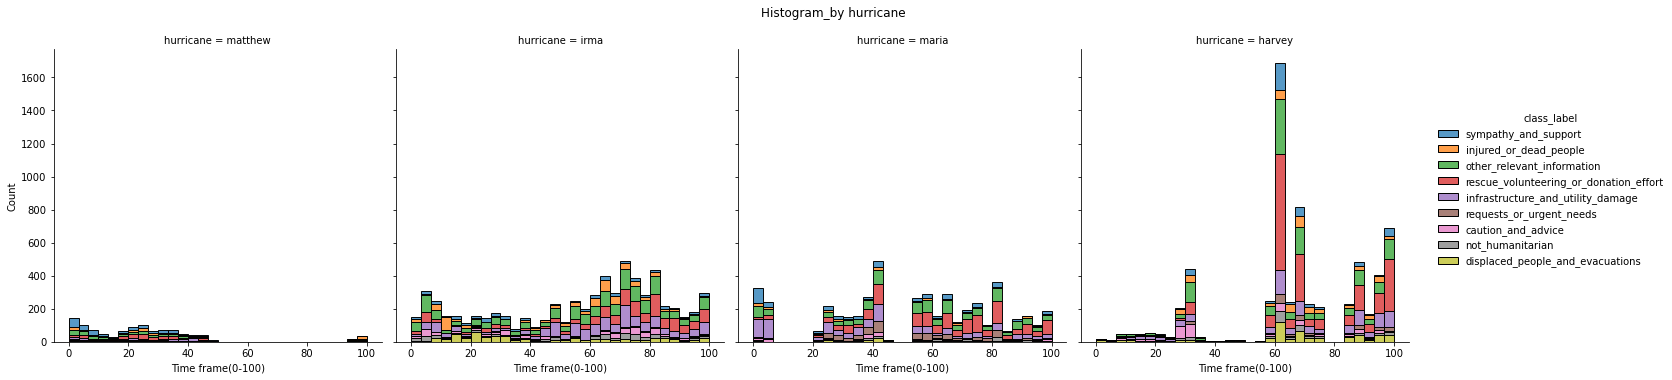

In [121]:
# facet grid with histograms - by hurricane
sns.displot(
    df, x="norm_date", col="hurricane", hue='class_label', multiple='stack', col_wrap=4,
    height=5, facet_kws=dict(margin_titles=True),
).set(xlabel='Time frame(0-100)', ylabel='Count').fig.suptitle('Histogram_by hurricane', y=1.05)

<AxesSubplot:xlabel='norm_date', ylabel='class_label'>

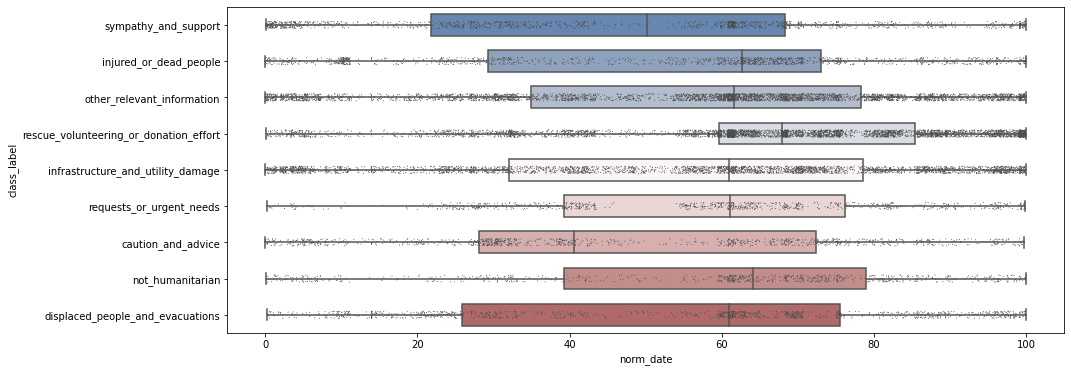

In [122]:
# label boxplot overtime, all hurricanes
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x="norm_date", y="class_label", data=df,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="norm_date", y="class_label", data=df,
              size=1, color=".3", linewidth=0)


##### Step. 4. Preprocess text data

In [123]:
# select or combine lemmatization, stemming, stopword removal to compare performance
stop_words = nltk.corpus.stopwords.words('english')

def preprocess_text(text, flg_stemm = True, flg_lemm = True, lst_stopwords=None):
    text_clean = re.sub(r'[^\w\s]', '', str(text).strip())
    lst_text = text_clean.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if flg_stemm == True:
        stemm = nltk.stem.porter.PorterStemmer()
        lst_text = [stemm.stem(word) for word in lst_text]
    if flg_lemm == True:
        lem=nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    text_clean = ' '.join(filter(None, lst_text))
    text_clean = text_clean.replace(" ,",",").replace(' .', '.')
    text_clean = contractions.fix(text_clean)
    return text_clean

df['pre_processed'] = df['text'].apply(lambda x: preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words))
df_processed = df[['pre_processed', 'class_label']]
df_processed.head()

,pre_processed,class_label
0,horrifi my heart break haiti think mani mani h...,sympathy_and_support
1,breakingnew hurrican matthew kill 800 haiti gl...,injured_or_dead_people
2,southern haiti effect cut bridg link capit por...,other_relevant_information
3,hurrican matthew hit haiti aim you east coast ...,other_relevant_information
4,our thought prayer today peopl haiti cuba ever...,sympathy_and_support


##### Step 5. Split dataset and transform to TF-IDF text representation

In [126]:
# train-test split (test size: 0.20)
df_processed['class_label'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(df_processed['pre_processed'], df_processed['class_label'], random_state=42, test_size=0.20, shuffle=True)

# Text representation to TFIDF
tfidf_vec = TfidfVectorizer(ngram_range=(1,1), lowercase=True, min_df = 1)
train_vc = tfidf_vec.fit_transform(X_train)
test_vc = tfidf_vec.transform(X_test)

In [127]:
# change label to fit for XGBoost model
le = LabelEncoder()
y_test_XG = le.fit_transform(y_test)
y_train_XG = le.fit_transform(y_train)

target_names = list(df['class_label'].unique())
bst = XGBClassifier(n_estimators=100, min_child_weight=4, gamma=0.1, reg_alpha=0.005, max_depth=6, subsample=0.9, colsample_bytree=0.9, learning_rate=0.2, objective='multi:softmax')
bst.fit(train_vc, y_train_XG)
preds = bst.predict(test_vc)

metrics.classification_report(y_test_XG, preds, target_names=target_names, output_dict=True)['accuracy']

0.7349654071314529

##### Step 6. Check initial performance on default classifiers

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,accuracy,precision,recall,f1-score
Logistic Regression,0.741618,0.734822,0.65757,0.677136
RandomForest,0.734433,0.719776,0.643767,0.656803


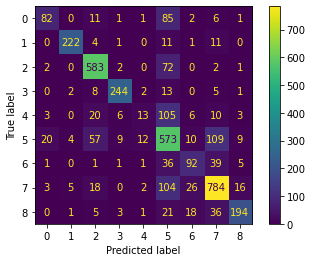

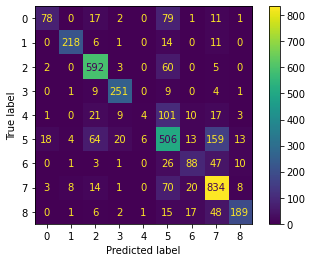

In [156]:
seed = 42

#boxed out number of classifiers to lower computational cost
#left best performing classifiers : Logistic Regression and RandomForest 
models = {"Logistic Regression": LogisticRegression(),
          #"MultinomialNB": MultinomialNB(),
          "RandomForest": RandomForestClassifier(),
          #"SVM": SVC(),
          #"MLP": MLPClassifier()
          }

results_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])
target_names = list(df['class_label'].unique())


for name, model in models.items():
    
    fit = model.fit(train_vc, y_train)
    pred = model.predict(test_vc)

    report_dict = metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)
        
    results_df.loc[name, 'accuracy'] = report_dict['accuracy']
    results_df.loc[name, 'precision'] = report_dict['macro avg']['precision']
    results_df.loc[name, 'recall'] = report_dict['macro avg']['recall']
    results_df.loc[name, 'f1-score'] = report_dict['macro avg']['f1-score']

    metrics.plot_confusion_matrix(fit, test_vc, y_test)

results_df

##### Step 7. Perform GridSearchCV to optimize classifiers

In [129]:
#classifier and parameter setting for gridsearch
#five-fold cross validation used
#created each classifier seperately due to computational cost
#boxed out due to computational cost

'''
lr_classifier = LogisticRegression()
#nb_classifier = MultinomialNB()
#rf_classifier = RandomForestClassifier()
#svm_classifier = SVC()
#MLPClassifier = MLPClassifier()

lr_parameters = {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10, 100], 'penalty' : ['l1', 'l2', 'elasticnet', 'none'], 'multi_class': ['auto', 'ovr', 'multinomial'], 'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga']}
#nb_parameters = {'alpha' : [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000], 'fit_prior' : ['True', 'False']}
#rf_parameters = {'n_estimators' : ['100', '200', '300'], 'max_depth': [3, 5, 10]}
#svc_parameters = {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10, 100], 'penalty' : ['l2', 'elasticnet'], 'multi_class': ['rbf', 'ovr', 'multinomial']}
#mlp_parameters = {'hidden_layer_sizes' : [10, 50, 100, 200], 'activation' : ['identity', 'logistic', 'tanh', 'relu'], 'alpha' : ['0.0001', '0.001', '0.01', '0.1']}

lr_best = GridSearchCV(lr_classifier, lr_parameters)
lr_best.fit(train_vc, y_train)
lr_best.best_params_
lr_pred = lr_best.predict(test_vc)
metrics.classification_report(y_test, lr_pred, target_names=target_names, output_dict=True)
'''

"""
nb_best = GridSearchCV(nb_classifier, nb_parameters, cv=5)
nb_best.fit(train_vc, y_train)
nb_best.best_params_
nb_pred = nb_best.predict(test_vc)
metrics.classification_report(y_test, nb_pred, target_names=target_names, output_dict=True)

rf_best = GridSearchCV(nb_classifier, nb_parameters, cv=5)
rf_best.fit(train_vc, y_train)
rf_best.best_params_
rf_pred = nb_best.predict(test_vc)
metrics.classification_report(y_test, rf_pred, target_names=target_names, output_dict=True)

svm_best = GridSearchCV(svc_classifier, svc_parameters, cv=5)
svm_best.fit(train_vc, y_train)
svm_best.best_params_
svm_pred = svm_best.predict(test_vc)
metrics.classification_report(y_test, svm_pred, target_names=target_names, output_dict=True)

mlp_best = GridSearchCV(MLPClassifier, mlp_parameters, cv=5)
mlp_best.fit(train_vc, y_train)
mlp_best.best_params_
mlp_pred = mlp_best.predict(test_vc)
metrics.classification_report(y_test, mlp_pred, target_names=target_names, output_dict=True)

#tune classifiers based on result of gridsearch
"""


'\nnb_best = GridSearchCV(nb_classifier, nb_parameters, cv=5)\nnb_best.fit(train_vc, y_train)\nnb_best.best_params_\nnb_pred = nb_best.predict(test_vc)\nmetrics.classification_report(y_test, nb_pred, target_names=target_names, output_dict=True)\n\nrf_best = GridSearchCV(nb_classifier, nb_parameters, cv=5)\nrf_best.fit(train_vc, y_train)\nrf_best.best_params_\nrf_pred = nb_best.predict(test_vc)\nmetrics.classification_report(y_test, rf_pred, target_names=target_names, output_dict=True)\n\nsvm_best = GridSearchCV(svc_classifier, svc_parameters, cv=5)\nsvm_best.fit(train_vc, y_train)\nsvm_best.best_params_\nsvm_pred = svm_best.predict(test_vc)\nmetrics.classification_report(y_test, svm_pred, target_names=target_names, output_dict=True)\n\nmlp_best = GridSearchCV(MLPClassifier, mlp_parameters, cv=5)\nmlp_best.fit(train_vc, y_train)\nmlp_best.best_params_\nmlp_pred = mlp_best.predict(test_vc)\nmetrics.classification_report(y_test, mlp_pred, target_names=target_names, output_dict=True)\n\n#t

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,accuracy,precision,recall,f1-score
Logistic Regression,0.742682,0.731772,0.6658,0.684113
RandomForest,0.733635,0.718626,0.637418,0.654416


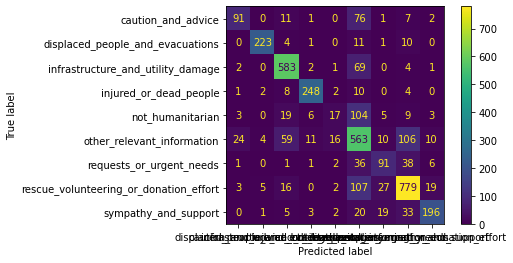

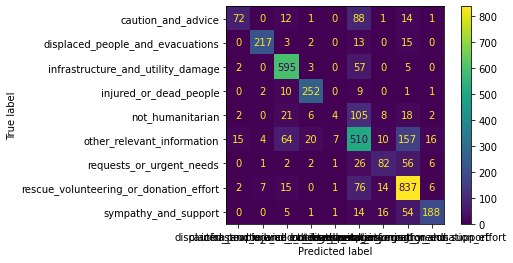

In [141]:
# test optimized classifiers

models = {"Logistic Regression": LogisticRegression(C=1.6, multi_class='multinomial'),
          #"MultinomialNB": MultinomialNB(fit_prior=False, alpha=5),
          "RandomForest": RandomForestClassifier(n_estimators=100, max_depth = None),
          #"SVC": SVC(kernel='poly', degree=2, C=10),
          #"MLP": MLPClassifier(hidden_layer_sizes=200, activation='tanh', solver='adam', alpha=0.001)
          }

#fit classifiers and make predictions

report_dict_lr = None
report_dict_rf = None
for name, model in models.items():
    
    fit = model.fit(train_vc, y_train)
    pred = model.predict(test_vc)

    report_dict = metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)
    if name == 'Logistic Regression':
        report_dict_lr = report_dict
    if name == 'RandomForest':
        report_dict_rf = report_dict
        
    results_df.loc[name, 'accuracy'] = report_dict['accuracy']
    results_df.loc[name, 'precision'] = report_dict['macro avg']['precision']
    results_df.loc[name, 'recall'] = report_dict['macro avg']['recall']
    results_df.loc[name, 'f1-score'] = report_dict['macro avg']['f1-score']

    metrics.plot_confusion_matrix(fit, test_vc, y_test)

results_df

,Class label,precision,recall,f1-score,support
0,sympathy_and_support,0.728000,0.481481,0.579618,189.000000
1,injured_or_dead_people,0.948936,0.892000,0.919588,250.000000
2,other_relevant_information,0.825779,0.880665,0.852339,662.000000
3,rescue_volunteering_or_donation_effort,0.908425,0.901818,0.905109,275.000000
4,infrastructure_and_utility_damage,0.404762,0.102410,0.163462,166.000000
5,requests_or_urgent_needs,0.565261,0.701121,0.625903,803.000000
6,caution_and_advice,0.590909,0.517045,0.551515,176.000000
7,not_humanitarian,0.786869,0.813152,0.799795,958.000000
8,displaced_people_and_evacuations,0.827004,0.702509,0.759690,279.000000
9,accuracy,0.742682,0.742682,0.742682,0.742682


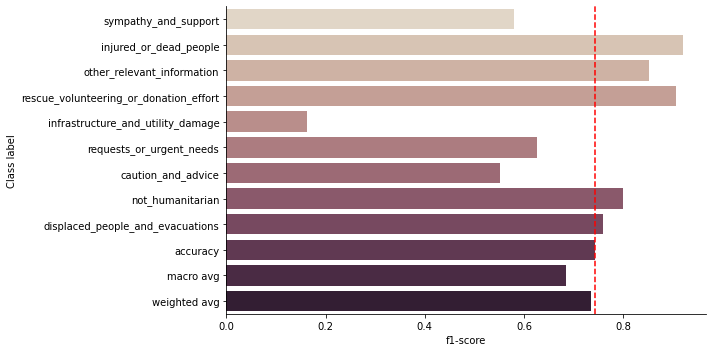

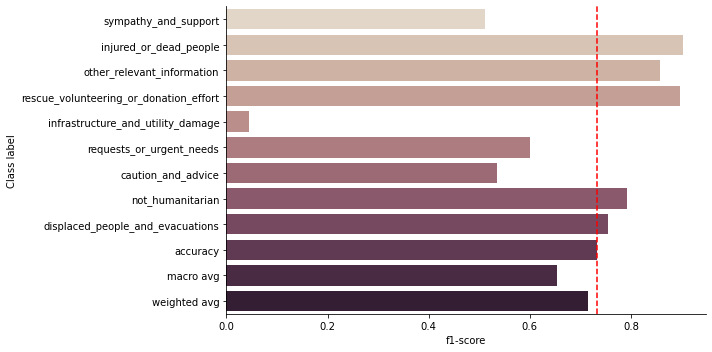

In [146]:
# plot precision, recall, f1-score for each class label
report_lr_df = pd.DataFrame(report_dict_lr).T.reset_index()
report_lr_df = report_lr_df.rename(columns={'index' : 'Class label'})

report_rf_df = pd.DataFrame(report_dict_rf).T.reset_index()
report_rf_df = report_rf_df.rename(columns={'index' : 'Class label'})

# Logistic regression plot
ax_lr = sns.catplot(data=report_lr_df, x="f1-score", y='Class label', kind='bar', palette="ch:.25", aspect=2).refline(x=0.742682, color='red') # add vertical line based on accuracy score

# RandomForest plot
ax_rf = sns.catplot(data=report_rf_df, x="f1-score", y='Class label', kind='bar', palette="ch:.25", aspect=2).refline(x=0.733635, color='red') # add vertical line based on accuracy score
report_lr_df

##### Step 8. Perform SHAP analysis

In [147]:
#SHAP analysis
#convert class_label to numeric to fit for SHAP analysis

le = preprocessing.LabelEncoder()
le.fit(df.class_label)
df['class_label_num'] = le.transform(df.class_label)
df.head(3)

,Unnamed: 0,tweet_id,text,class_label,hurricane,fatalities,damage(billion USD),author_id,created_at,conversation_id,...,lang,possibly_sensitive,public_metrics,referenced_tweets,reply_settings,source,date,norm_date,pre_processed,class_label_num
0,0,783409770493571076,Horrifying. My heart breaks for Haiti. Thinkin...,sympathy_and_support,matthew,603,16.47,3.031696e+07,2016-10-04 20:53:38+00:00,7.834098e+17,...,en,no value,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",[<ReferencedTweet id=783408890222444548 type=q...,everyone,TweetDeck,2016-10-04 20:53:38+00:00,2.052895,horrifi my heart break haiti think mani mani h...,8
1,1,784696725285908481,#BreakingNews Hurricane Matthew kills over 800...,injured_or_dead_people,matthew,603,16.47,2.182497e+09,2016-10-08 10:07:32+00:00,7.846967e+17,...,en,no value,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",no value,everyone,dlvr.it,2016-10-08 10:07:32+00:00,99.741796,breakingnew hurrican matthew kill 800 haiti gl...,3
2,2,783549594416377856,Southern Haiti effectively cut off after the b...,other_relevant_information,matthew,603,16.47,9.788374e+07,2016-10-05 06:09:15+00:00,7.835496e+17,...,en,no value,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",[<ReferencedTweet id=783548240650244097 type=q...,everyone,Twitter for Windows Phone,2016-10-05 06:09:15+00:00,12.666631,southern haiti effect cut bridg link capit por...,5


100%|██████████| 5/5 [02:07<00:00, 25.41s/it]


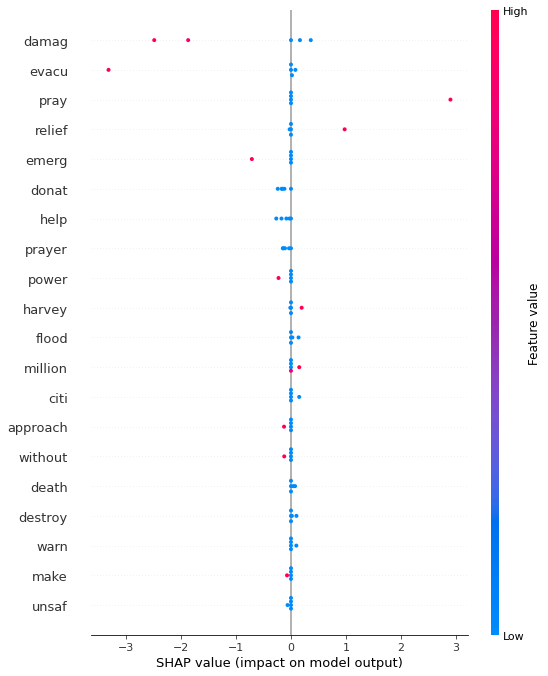

In [148]:
# Logistic Regression SHAP analysis example

X_train, X_test, y_train, y_test = train_test_split(df['pre_processed'], df['class_label_num'], random_state=42, test_size=0.20, shuffle=True)

tfidf_vec = TfidfVectorizer(ngram_range=(1,1), lowercase=True, min_df = 1)
train_vc = tfidf_vec.fit_transform(X_train)
test_vc = tfidf_vec.transform(X_test)

lr_classifier = LogisticRegression(C=1, multi_class='multinomial', penalty='l1', solver='saga')
lr_classifier.fit(train_vc, y_train)

X_train_sample = shap.sample(train_vc, 100)
X_test_sample = shap.sample(test_vc, 5)
explainer = shap.KernelExplainer(lr_classifier.predict, X_train_sample, l1_reg="rank(3)")
shap_vals = explainer.shap_values(X_test_sample)
colour_df = pd.DataFrame(X_test_sample.todense())
shap.summary_plot(shap_vals, colour_df, feature_names=tfidf_vec.get_feature_names())

In [149]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_vals[1,:], 
                colour_df.iloc[1,:], feature_names=tfidf_vec.get_feature_names())

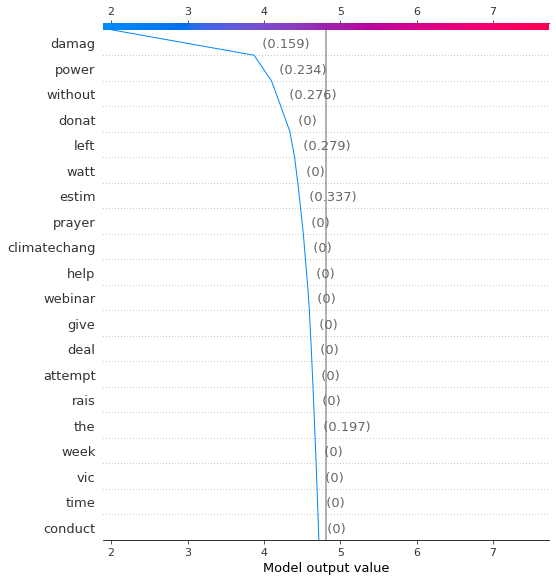

In [150]:
shap.decision_plot(explainer.expected_value, shap_vals[1,:], 
                colour_df.iloc[1,:], feature_names=tfidf_vec.get_feature_names())

##### Step 9. Predict test (unseen) dataset

In [151]:
#load test dataset and preprocess and vectorize through TFIDF
df_test = pd.read_csv('test_hurricane_with_name.csv')
df_test = df_test.drop_duplicates(subset=['text'], keep=False)  # drop duplicates in dataset
df_test['date'] = pd.to_datetime(df_test['created_at'])

df_test['pre_processed'] = df_test['text'].apply(lambda x: preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words))
pred_vc = tfidf_vec.transform(df_test['pre_processed'])

In [152]:
#make label prediction and export as csv
lr_pred = lr_classifier.predict(pred_vc)
lr_pred = le.inverse_transform(a)
df_test['class_label'] = lr_pred

df_test.to_csv('df_test_predicted.csv')

df_test.head(3)

ValueError: y contains previously unseen labels: [ 9 10 11 12]

##### Step 10. Basic EDA of predicted test dataset

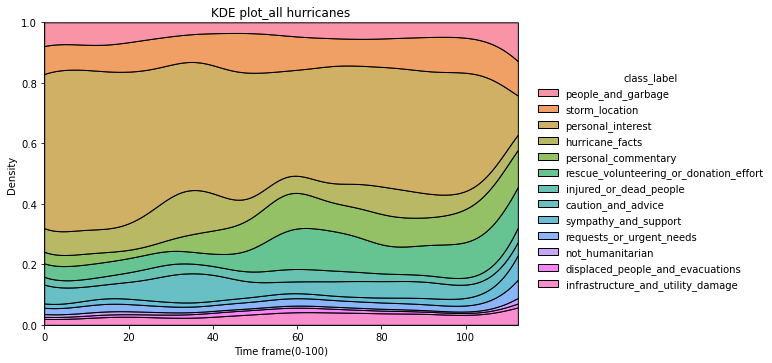

In [111]:
# kernel density estimate plot - all hurricanes
ax_kde = sns.displot(
    data=df_test,
    x="norm_date", hue="class_label",
    kind="kde", height=5, aspect=1.5,
    multiple="fill", clip=(0, None)
).set(title='KDE plot_all hurricanes_test', xlabel='Time frame(0-100)', ylabel='Density')

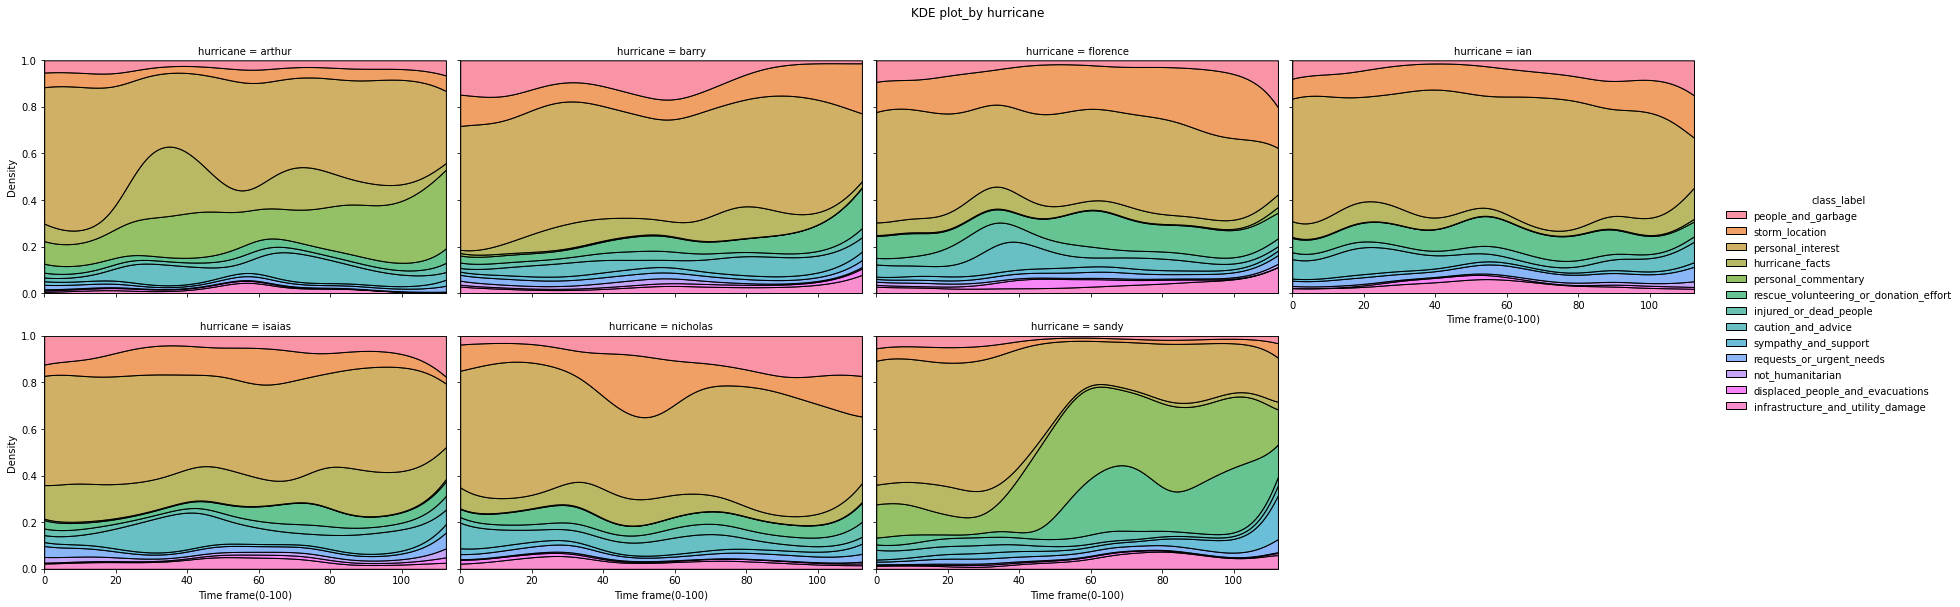

In [113]:
# kernel density estimate plot - by hurricane
ax_kde_by_hurricanes = sns.displot(
    data=df_test,
    x="norm_date", col='hurricane', hue="class_label",
    kind="kde", height=4, aspect=1.5,
    multiple="fill", clip=(0, None), col_wrap=4
).set(xlabel='Time frame(0-100)', ylabel='Density').fig.suptitle('KDE plot_by hurricane_test', y=1.05)

In [ ]:
# facet grid with histograms - by hurricane
sns.displot(
    df_test, x="norm_date", col="hurricane", hue='class_label', multiple='stack', col_wrap=4,
    height=5, facet_kws=dict(margin_titles=True),
).set(xlabel='Time frame(0-100)', ylabel='Count').fig.suptitle('Histogram_by hurricane_test', y=1.05)

In [ ]:
# label boxplot overtime, all hurricanes
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x="norm_date", y="class_label", data=df,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="norm_date", y="class_label", data=df,
              size=1, color=".3", linewidth=0)
